In [1]:
# add sys path to load src
import sys
sys.path.append('../')

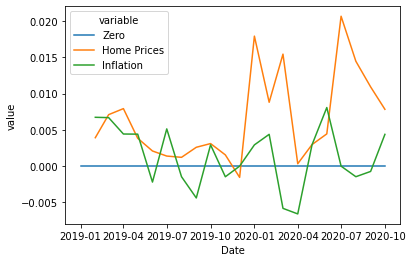

In [2]:
# libraries
import seaborn as sns
import pandas as pd

# import data functions
from src import make_datasets, merge_datasets

real_estate_df = make_datasets.make_real_estate_df()
inflation_df = make_datasets.make_inflation_df()

# load and merge the data
change_df = merge_datasets.merge_realestate_df(real_estate_df[['Date', 'Composite_Benchmark_Change']], inflation_df[['Date', 'Inflation_Change']])

# save the cleaned data
change_df.to_csv('../data/processed/real_estate_change.csv')

# plot dataframe
sns.lineplot(x='Date', y='value', hue='variable', 
             data=pd.melt(change_df.rename(columns={'Composite_Benchmark_Change': 'Home Prices', 'Inflation_Change': 'Inflation'}), ['Date']))

In [3]:
change_df = change_df.set_index(['Date']).resample(rule='d').interpolate()
change_rolling = change_df.rolling(window = 21).mean().dropna()

In [5]:
from src import make_models
from matplotlib import pyplot as plt

arima_real_estate_df = change_rolling.reset_index()
arima_real_estate_df = arima_real_estate_df.loc[arima_real_estate_df['Date'] < '2020-03-01']

model = make_models.make_real_estate_model(df=arima_real_estate_df)

model.plot_diagnostics(figsize=(7,7))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5400.980, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5398.966, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5397.445, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.897 seconds


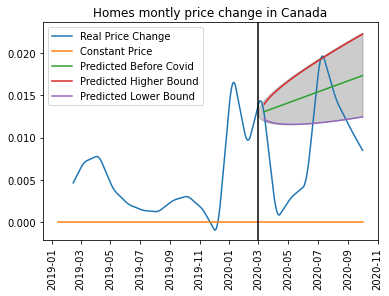

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import datetime as dt

from src import make_models

fitted_series, lower_series, upper_series = make_models.make_real_estate_predictions(model=model, df=arima_real_estate_df)

real_estate_df = make_datasets.make_real_estate_df().set_index(['Date']).resample(rule='d').interpolate().reset_index()

first_day_arima = arima_real_estate_df.reset_index().iloc[0]['Date']
last_day_arima = arima_real_estate_df.reset_index().iloc[-1]['Date']

change_df = change_df[['Composite_Benchmark_Change', 'Zero']]
change_df['Prediction'] = fitted_series
change_df['Prediction_High'] = upper_series
change_df['Prediction_Low'] = lower_series


plt.fill_between(change_df['Prediction_Low'].index, 
                 change_df['Prediction_Low'], 
                 change_df['Prediction_High'], 
                 color='k', alpha=.20)

plt.title("Homes montly price change in Canada")

change_rolling = change_df.rolling(window = 14).mean()
plt.plot(change_rolling)
plt.legend(['Real Price Change', 'Constant Price', 'Predicted Before Covid', 'Predicted Higher Bound', 'Predicted Lower Bound'])
plt.xticks(rotation=90)
plt.axvline(dt.datetime(2020, 2, 29) , color='black')